# Partial differential equations


In [4]:
import numpy as np

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, Image

%matplotlib inline


# Partial differential equations

+ Think of these as an infinite set of ordinary differential equations is called a partial differential equation (PDE).
+ In numerical methods, we split up this set into a finite set of ODEs, usually by "meshing" the domain into a finite set of points.

There are several types of PDEs, elliptical, hyperbolic, and parabolic.



| Type     | Equation | Example     |
| :---        |    :----:   |    :----:   |
| Elliptical      | $u'' + u'' = 0$      | Laplace's equation      |
| Hyperbolic      | $\ddot{u} = u''$       | Wave equation      |
| Parabolic      | $\dot{u} = u''$       | Heat equation      |

where $u' = \frac{\partial u}{\partial x}$ and $\dot{u} = \frac{\partial u}{\partial t}$ in the table


#### Today, we will focus on elliptical and parabolic PDEs

## The stability of linear dynamical systems

Recall that a linear dynamical system has the form

$$
\mathbf{x}_{t + 1} = A \mathbf{x}_{t}
$$

where $A$ is a matrix. We can think of this as a map from $\mathbb{R}^N \to \mathbb{R}^N$.

Depending on whether $\max_i |\lambda_i| < 1$, $\max_i |\lambda_i| = 1$, or $\max_i |\lambda_i| > 1$, the system will be stable, marginally stable, or unstable.

Eigenvalues of symmetric transition matrix:  [2.70882253 0.6372352 ]


Text(0.5, 0, 'Time step')

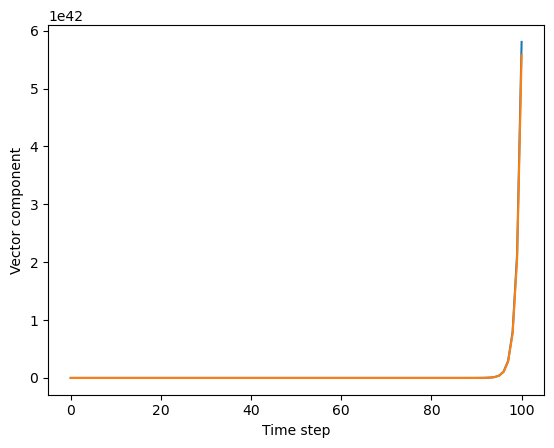

In [4]:
a = np.random.random((2, 2))
a += a.T

print("Eigenvalues of symmetric transition matrix: ", np.linalg.eigvals(a))

all_u = [np.random.random(2)]
for _ in range(100):
    all_u.append(a @ all_u[-1])

all_u = np.array(all_u)

plt.plot(all_u[:, 0])
plt.plot(all_u[:, 1])

plt.ylabel("Vector component")
plt.xlabel("Time step")


## Stability analysis of a finite difference scheme

In one dimension, the diffusion equation is given by

$$
\frac{\partial}{\partial t}u(x,t) = D\frac{\partial^2}{\partial x^2} u(x,t)
$$

We can approximate this equation using first-order finite differences in space and time

$$
\frac{u(x, t + \Delta t) - u(x, t)}{\Delta t} = D \frac{u(x + \Delta x, t) - 2 u(x, t) + u(x - \Delta x, t)}{\Delta x^2}
$$

We use the index $i$ to denote different lattice points in space, and $n$ to denote different time steps. We rearrange terms to write this equation as a matrix equation that updates $u_i$ at each time step

$$
u_i^{n + 1} = u_i^n + \frac{\Delta t D}{\Delta x^2} \left(u_{i + 1}^n - 2 u_i^n + u_{i - 1}^n\right)
$$

Notice that we can write the right-hand side of this differential equation as a constant matrix $\mathbb{I} + A$ acting on the vector $\mathbf{u}^n$

$$
\mathbf{u}^{n + 1} = \left(\mathbb{I} + \frac{\Delta t D}{\Delta x^2}A\right) \mathbf{u}^n
$$

where $A$ is a tridiagonal matrix with $-2$ on the diagonal, and $1$ on the off-diagonals. In general, we can always write *linear* partial differential equations as linear matrix equations in discrete time.


Text(0, 0.5, 'x')

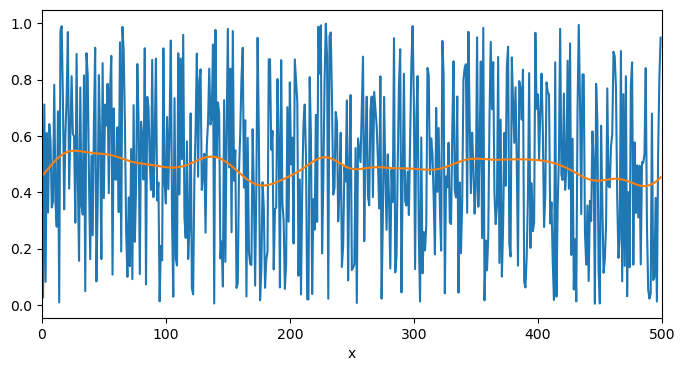

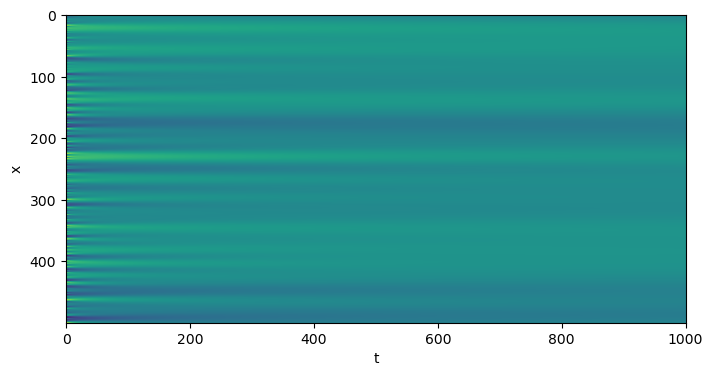

In [5]:
def laplacian(n, dx=1.0):
    """
    Create a one-dimensional discrete Laplacian operator with periodic boundary conditions.

    Args:
        n (int): The number of grid points.
        dx (float): The grid spacing.

    Returns:
        ndarray: The Laplacian operator in one dimension.
    """
    op = np.zeros((n, n))

    # set diag to -2
    np.fill_diagonal(op, -2)

    # set off-diag to 1
    np.fill_diagonal(op[:, 1:], 1)
    np.fill_diagonal(op[1:, :], 1)

    # set periodic boundary conditions
    op[0, -1] = 1
    op[-1, 0] = 1

    return op / dx**2


class DiscretizedPDE:
    """
    A base class for discretized PDEs in one dimension.

    Parameters
        n (int): The number of grid points in one dimension
        dx (float): The grid spacing
        dt (float): The time step
        store_history (bool): Whether to store the history of the solution
        random_state (int): The random seed

    """

    def __init__(self, n, dx=1.0, dt=1.0, store_history=True, random_state=0):
        self.n = n
        self.dt = dt
        self.dx = dx
        self.store_history = store_history
        self.random_state = random_state

    def rhs(self, u):
        raise NotImplementedError
    
    def solve(self, u0, nt):
        u = u0
        if self.store_history:
            self.history = [u0.copy()]
        for i in range(nt):
            u += self.rhs(u) * self.dt
            if self.store_history:
                self.history.append(u.copy())
        return u
    
class DiffusionEquation(DiscretizedPDE):
    """
    A class for discretized diffusion equations in one dimension.
    """
    def __init__(self, D=1.0, **kwargs):
        super().__init__(**kwargs)
        self.D = D
        self.lap = laplacian(self.n, self.dx)

    def rhs(self, u):
        return self.D * self.lap @ u
    
eq = DiffusionEquation(n=500, dx=1.0, dt=0.1, D=1.0, store_history=True)

# Initial condition
u0 = np.random.random(500).copy()

# Solve the equation
u = eq.solve(u0, 1000)

plt.figure(figsize=(8, 4))
plt.plot(eq.history[0])
plt.plot(eq.history[-1])
plt.xlim(0, len(u0))
plt.xlabel("x")
    
plt.figure(figsize=(8, 4))
plt.imshow(np.array(eq.history).T, aspect='auto')
plt.xlabel("t")
plt.ylabel("x")


### Can we perform fewer operations?

Suppose we want to do the numerical integration a lot faster. One option might be to increase $\Delta t$ and $\Delta x$. But is there a limit to how far we can go? Let's do a simple experiment to find out.

Text(0, 0.5, 'Max field value')

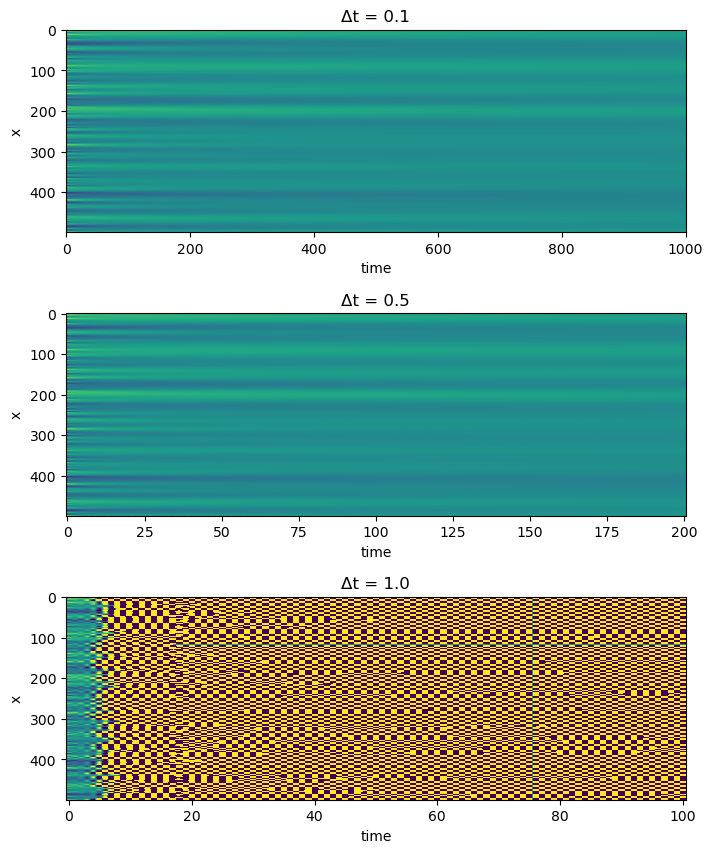

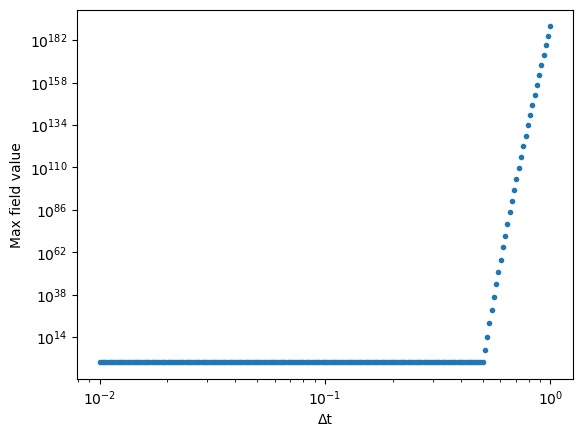

In [6]:

# Initial condition
u0 = np.random.random(500)


# make three subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 10))
plt.subplots_adjust(wspace=0.0, hspace=0.4)

eq = DiffusionEquation(n=500, dx=1.0, dt=0.1, D=1.0, store_history=True)
u = eq.solve(u0.copy(), 1000)

# make figure subplot
plt.subplot(3, 1, 1)
plt.imshow(np.array(eq.history).T, aspect='auto', vmin=0, vmax=1)
plt.xlabel("time")
plt.ylabel("x")
plt.title("Δt = 0.1")

eq = DiffusionEquation(n=500, dx=1.0, dt=0.5, D=1.0, store_history=True)
u = eq.solve(u0.copy(), 200)
plt.subplot(3, 1, 2)
plt.imshow(np.array(eq.history).T, aspect='auto', vmin=0, vmax=1)
plt.xlabel("time")
plt.ylabel("x")
plt.title("Δt = 0.5")

eq = DiffusionEquation(n=500, dx=1.0, dt=1.0, D=1.0, store_history=True)
u = eq.solve(u0.copy(), 100)
plt.subplot(3, 1, 3)
plt.imshow(np.array(eq.history).T, aspect='auto', vmin=0, vmax=1)
plt.xlabel("time")
plt.ylabel("x")
plt.title("Δt = 1.0")


dt_vals = np.logspace(-2, 0, 200)
max_field = []
for dt_val in dt_vals:
    eq = DiffusionEquation(n=500, dx=1.0, dt=dt_val, D=1.0, store_history=True)
    u = eq.solve(u0.copy(), 400)
    max_field.append(np.max(np.abs(u)))

plt.figure()
plt.loglog(dt_vals, max_field, '.')
plt.xlabel("Δt")
plt.ylabel("Max field value")

Recall that our discrete time, discrete-space diffusion equation is

$$
\mathbf{u}^{n + 1} = \left(\mathbb{I} + \frac{\Delta t D}{\Delta x^2}A\right) \mathbf{u}^n
$$

Due to the periodic boundary conditions, can be shown that the eigenvalues of $\mathbb{I} + A$ are

$$
\lambda_n = 1 + \frac{\Delta t D}{\Delta x^2}\left(-2 - 2 \cos\left(\frac{\pi n}{N}\right)\right)
$$

where $N$ is the number of lattice points and $n \in [0, N - 1]$. 

<!-- The condition number of this matrix is therefore

$$
\kappa = \frac{|\lambda_{max}|}{|\lambda_{min}|}
$$

As $N \rightarrow \infty$, $\kappa \sim N \rightarrow \infty$ -->


Text(0, 0.5, 'Max Eigenvalue')

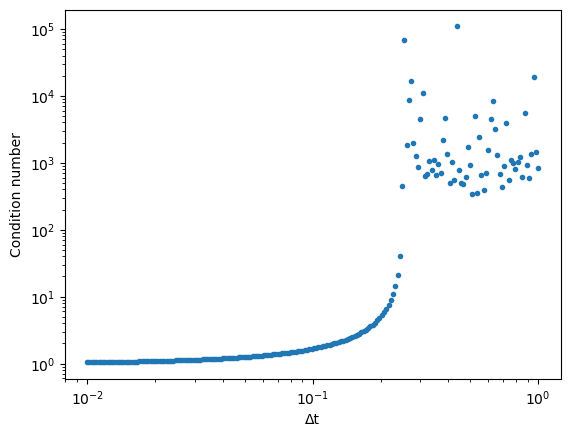

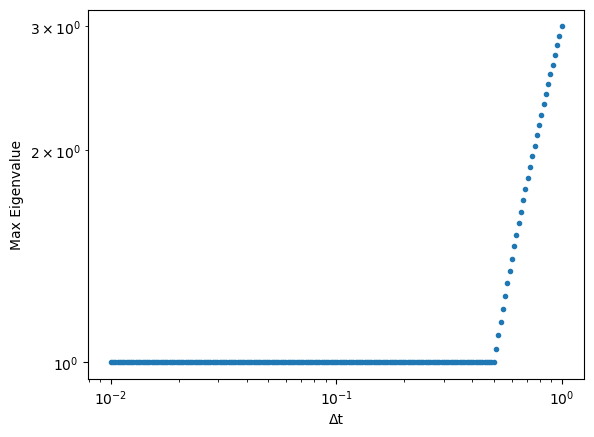

In [7]:
def eigenvalues_diffusion(n, dx=1.0, dt=1.0, D=1.0):
    """
    Compute the eigenvalues of the diffusion equation in one dimension.

    Args:
        n (int): The number of grid points.
        dx (float): The grid spacing.
        dt (float): The time step.
        D (float): The diffusion coefficient.

    Returns:
        ndarray: The eigenvalues of the diffusion equation.
    """
    nvals = np.arange(n)
    return 1 - (D * dt / dx**2) * (2 * np.cos(np.pi * nvals / n) + 2)

# plt.plot(eigenvalues_diffusion(500, dt=0.1, D=1.0))


max_eig, min_eig = [], []
all_conds = []
p2 = []
for dt_val in dt_vals:
    eigs_diff = eigenvalues_diffusion(500, dx=1.0, dt=dt_val, D=1.0)
    max_eig.append(np.max(np.abs(eigs_diff)))
    min_eig.append(np.min(np.abs(eigs_diff)))
    cond = np.max(np.abs(eigs_diff)) / np.min(np.abs(eigs_diff))
    all_conds.append(cond)
    # plt.plot(eigs_diff)

    ## We could also compute the condition number of the propagation matrix directly
    ## But this is more computationally expensive
    # eq = DiffusionEquation(n=500, dx=1.0, dt=dt_val, D=1.0)
    # prop = np.identity(500) + (eq.D * eq.dt / eq.dx**2) * eq.lap
    # cond = np.linalg.cond(prop)
    # all_conds.append(cond)



plt.figure()
plt.loglog(dt_vals, all_conds, '.')
plt.xlabel("Δt")
plt.ylabel("Condition number")

plt.figure()
plt.loglog(dt_vals, max_eig, '.')
plt.xlabel("Δt")
plt.ylabel("Max Eigenvalue")

# n=500, dx=1.0, dt=dt_val, D=1.0, 


We can see that the abrupt divergence in the dynamics of the simulation arises from the largest-norm eigenvalue rapidly increasing as we increase $\Delta t$. This abrupt change suggests that an abrupt change occurs in the underlying spectrum $\lambda_n$.

It turns out that we can trace this discontinuity to the discontinuous max function in $\max_n |\lambda_{n}|$. The value of $i$ that maximizes $|\lambda_n|$ abruptly changes.

$$
\lambda_n = 1 - \frac{\Delta t D}{\Delta x^2}\left(2 + 2 \cos\left(\frac{\pi n}{N}\right)\right)
$$

Because this is a monotonic function, the only two options for the maximum $n$ occur at the endpoints of the interval $[0, N - 1]$. Thus, 

$$
\max_n |\lambda_{n}| = \left\{
    |1 - 4\frac{\Delta t D}{\Delta x^2}|, 
    1 - \frac{\Delta t D}{\Delta x^2}\left(2 + 2 \cos\left(\frac{\pi (N-1)}{N}\right)\right)
\right\}
$$

In the limit $N\rightarrow\infty$, we can simplify this expression,
$$
\max_n |\lambda_{n}| = \left\{
    |1 - 4\frac{\Delta t D}{\Delta x^2}|, \;\;\;
    1
\right\}
$$

The crossover point therefore corresponds to the condition

$$
\dfrac12 = \frac{\Delta t D}{\Delta x^2}
$$

which, for our parameter values, corresponds to $\Delta t = 1/2$. This condition relating the diffusivity, timestep, and lattice discretization represents an example of [von Neumann stability analysis](https://en.wikipedia.org/wiki/Von_Neumann_stability_analysis) for finite difference schemes.


# Questions

+ Why did we call the `laplacian` function in the `__init__` method of the `Diffusion` class? Why not call it within the `rhs` method?

+ A common hyperbolic PDE is the wave equation:

$$
\frac{\partial^2}{\partial t^2}u(x,t) = c^2\frac{\partial^2}{\partial x^2} u(x,t)
$$

where $c$ is the speed of the wave. Based on the form of the von Neumann condition, what would you expect the linear stability condition for this equation to be?

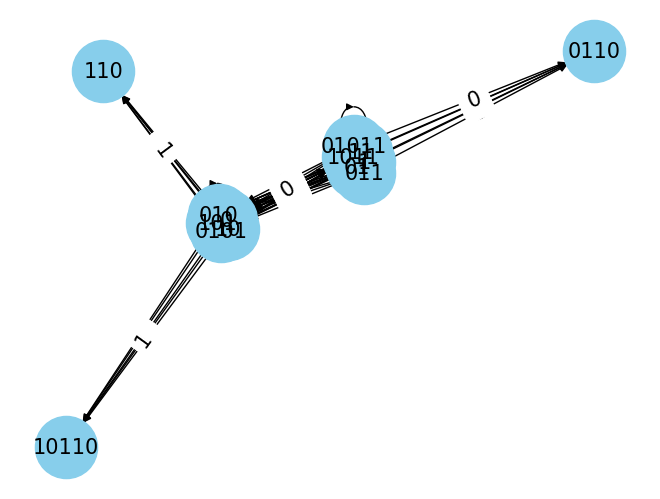

In [11]:
import networkx as nx

class EpsilonMachine:
    def __init__(self, sequence):
        self.sequence = sequence
        self.graph = nx.DiGraph()
        self.construct_machine()

    def get_subtrees(self, L):
        """Returns all L-length subsequences from the sequence."""
        return [self.sequence[i:i+L] for i in range(len(self.sequence) - L + 1)]

    def equivalence_classes(self):
        """Identify equivalence classes based on subtree similarity."""
        classes = {}
        max_L = len(self.sequence)

        for L in range(1, max_L):
            subtrees = self.get_subtrees(L)
            for i, subtree in enumerate(subtrees):
                if subtree not in classes:
                    classes[subtree] = []
                classes[subtree].append(i)

        return classes

    def construct_machine(self):
        """Construct the ε-machine graph."""
        classes = self.equivalence_classes()

        # Add nodes for each equivalence class
        for eq_class in classes:
            self.graph.add_node(eq_class)

        # Add edges based on transitions
        for eq_class in classes:
            index = classes[eq_class][0] + len(eq_class)
            if index < len(self.sequence):  # Check if index is within bounds
                next_symbol = self.sequence[index]
                for other_class in classes:
                    if other_class.startswith(next_symbol):
                        self.graph.add_edge(eq_class, other_class, label=next_symbol)


    def display_machine(self):
        """Visualize the ε-machine using matplotlib."""
        pos = nx.spring_layout(self.graph)
        labels = nx.get_edge_attributes(self.graph, 'label')
        nx.draw(self.graph, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=15)
        nx.draw_networkx_edge_labels(self.graph, pos, edge_labels=labels, font_size=15)
        plt.show()

# Example usage
sequence = "010110"
machine = EpsilonMachine(sequence)
machine.display_machine()

<!-- $$
u_{i,j}^{n+1} = u_{i,j}^{n} + \frac{D\Delta t}{2} \left( \frac{1}{\Delta x^{2}} \left( u_{i+1,j}^{n} - 2u_{i,j}^{n} + u_{i-1,j}^{n} \right) + \frac{1}{\Delta y^{2}} \left( u_{i,j+1}^{n} - 2u_{i,j}^{n} + u_{i,j-1}^{n} \right) \right)
$$

$$
+ \frac{D\Delta t}{2} \left( \frac{1}{\Delta x^{2}} \left( u_{i+1,j}^{n+1} - 2u_{i,j}^{n+1} + u_{i-1,j}^{n+1} \right) + \frac{1}{\Delta y^{2}} \left( u_{i,j+1}^{n+1} - 2u_{i,j}^{n+1} + u_{i,j-1}^{n+1} \right) \right)
$$ -->

<!-- $$
u_{i,j}^{n+1} = u_{i,j}^{n} + \frac{D\Delta t}{2} \left( \frac{1}{\Delta x^{2}} \left( u_{i+1,j}^{n} - 2u_{i,j}^{n} + u_{i-1,j}^{n} \right) + \frac{1}{\Delta y^{2}} \left( u_{i,j+1}^{n} - 2u_{i,j}^{n} + u_{i,j-1}^{n} \right) \right)
$$

$$
+ \frac{D\Delta t}{2} \left( \frac{1}{\Delta x^{2}} \left( u_{i+1,j}^{n+1} - 2u_{i,j}^{n+1} + u_{i-1,j}^{n+1} \right) + \frac{1}{\Delta y^{2}} \left( u_{i,j+1}^{n+1} - 2u_{i,j}^{n+1} + u_{i,j-1}^{n+1} \right) \right)
$$ -->